# **Model Implementation**

In [1]:
from datasets import load_dataset
from huggingface_hub import login
import os
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import gc

print("Streaming dataset...")
ds_stream = load_dataset("saberzl/SID_Set", split="train", streaming=True)

# Step 3: Setup directories for 3 classes
save_dir = "/content/sid_images"
os.makedirs(f"{save_dir}/real", exist_ok=True)
os.makedirs(f"{save_dir}/synthetic", exist_ok=True)
os.makedirs(f"{save_dir}/tampered", exist_ok=True)

target_per_class = 3600
class_counts = {'real': 0, 'synthetic': 0, 'tampered': 0}

print(f"Downloading {target_per_class} images per class (Real, Synthetic, Tampered)...")
print("Saving images directly to disk to avoid memory issues\n")

pbar = tqdm(ds_stream)
for sample in pbar:
    # Get label (0=Real, 1=Synthetic, 2=Tampered)
    label = sample.get('label', sample.get('class', None))

    if label is None:
        print(f"Available keys: {sample.keys()}")
        break

    # Map label to class name
    if label == 0:
        class_name = 'real'
    elif label == 1:
        class_name = 'synthetic'
    elif label == 2:
        class_name = 'tampered'
    else:
        continue

    if class_counts[class_name] >= target_per_class:
        if all(count >= target_per_class for count in class_counts.values()):
            print("\n Downloaded target number for all classes!")
            break
        continue

    if 'image' in sample:
        img = sample['image']
        if isinstance(img, Image.Image):
            class_counts[class_name] += 1
            img_filename = f"{class_name}_{class_counts[class_name]:05d}.png"
            img_path = f"{save_dir}/{class_name}/{img_filename}"

            # Convert all images to RGB (handles RGBA, CMYK, L, etc.)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Save as PNG
            img.save(img_path, 'PNG')
            img.close()

            # Update progress bar
            pbar.set_description(
                f"Real: {class_counts['real']}/{target_per_class} | "
                f"Synth: {class_counts['synthetic']}/{target_per_class} | "
                f"Tamp: {class_counts['tampered']}/{target_per_class}"
            )

            # Force garbage collection every 100 images
            if sum(class_counts.values()) % 100 == 0:
                gc.collect()

pbar.close()

print(f"\n{'='*70}")
print(f"Download Complete!")
print(f"{'='*70}")
print(f"Real images:      {class_counts['real']}")
print(f"Synthetic images: {class_counts['synthetic']}")
print(f"Tampered images:  {class_counts['tampered']}")
print(f"Total images:     {sum(class_counts.values())}")
print(f"Images saved to:  {save_dir}")
print(f"{'='*70}")

# Step 4: Create PyTorch Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load real images (label 0)
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images (label 1)
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images (label 2)
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        print(f"\nDataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label



Streaming dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Saving images directly to disk to avoid memory issues



Real: 840/3600 | Synth: 848/3600 | Tamp: 855/3600: : 2543it [16:03,  2.39it/s]'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 85df1f20-e56f-48a7-b5b0-7e18b5a56da7)')' thrown while requesting GET https://huggingface.co/datasets/saberzl/SID_Set/resolve/dc03ead57929879319ce30a82bfcfb8d317b10bd/data/train-00003-of-00249.parquet
Retrying in 1s [Retry 1/5].
Real: 2007/3600 | Synth: 1930/3600 | Tamp: 1988/3600: : 5925it [37:13,  2.25it/s]'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 74fa182d-6777-4bd2-bf0e-3c747f57eb28)')' thrown while requesting GET https://huggingface.co/datasets/saberzl/SID_Set/resolve/dc03ead57929879319ce30a82bfcfb8d317b10bd/data/train-00007-of-00249.parquet
Retrying in 1s [Retry 1/5].
Real: 3600/3600 | Synth: 3600/3600 | Tamp: 3600/3600: : 10858it [1:07:54,  2.67it/s]



 Downloaded target number for all classes!

Download Complete!
Real images:      3600
Synthetic images: 3600
Tampered images:  3600
Total images:     10800
Images saved to:  /content/sid_images


In [2]:
!pip install torch torchvision tqdm pillow -q

# Importing librarires

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import matplotlib.pyplot as plt
import seaborn as sns

#Configuration

In [4]:


class Config:
    # Paths
    data_dir = '/content/sid_images'
    save_dir = './checkpoints'

    # Model
    backbone = 'resnet50'
    pretrained = True
    num_classes = 3

    # Training
    epochs = 20
    batch_size = 32
    lr = 1e-4
    weight_decay = 1e-4
    num_workers = 2


    save_freq = 5
    seed = 42

config = Config()

#random seed for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

print("Configuration loaded!")
print(f"Data directory: {config.data_dir}")
print(f"Save directory: {config.save_dir}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")



Configuration loaded!
Data directory: /content/sid_images
Save directory: ./checkpoints
Device: GPU


#Dataset Class

In [5]:
class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load real images
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        # Split into train/val
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        split_idx = int(0.8 * len(self.samples))

        if split == 'train':
            indices = indices[:split_idx]
        else:
            indices = indices[split_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Dataset class defined!")

Dataset class defined!


#Model Definition

In [6]:
class SimpleSIDA(nn.Module):

    def __init__(self, num_classes=3, backbone='resnet50', pretrained=True):
        super(SimpleSIDA, self).__init__()

        from torchvision.models import resnet50, ResNet50_Weights
        if pretrained:
            self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        else:
            self.backbone = resnet50(weights=None)

        self.feature_dim = self.backbone.fc.in_features
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        self.cls_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.cls_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        features = features.flatten(1)
        logits = self.cls_head(features)
        return logits

print("Model class defined!")

Model class defined!


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

print("Training function defined!")

Training function defined!


In [8]:
def validate(model, dataloader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    num_classes = 3
    confusion_matrix = torch.zeros(num_classes, num_classes)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Val]")
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.cpu(), predicted.cpu()):
                confusion_matrix[t.long(), p.long()] += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    class_names = ['Real', 'Synthetic', 'Tampered']
    per_class_metrics = {}

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp

        total_class = confusion_matrix[i, :].sum()
        class_acc = float(tp / total_class) if total_class > 0 else 0.0
        precision = float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0
        recall = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        per_class_metrics[class_names[i]] = {
            'accuracy': class_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    print(f"\n{'='*60}")
    print(f"Validation Results (Epoch {epoch+1}):")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Average Loss: {avg_loss:.4f}")
    print("\nPer-Class Metrics:")
    for class_name, metrics in per_class_metrics.items():
        print(f"\n{class_name}:")
        print(f"  Accuracy:  {metrics['accuracy']*100:.2f}%")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1:        {metrics['f1']:.4f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}", end="")
    for name in class_names:
        print(f"{name:>12}", end="")
    print()
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12}", end="")
        for j in range(num_classes):
            print(f"{int(confusion_matrix[i, j]):>12}", end="")
        print()
    print(f"{'='*60}\n")

    return avg_loss, accuracy, per_class_metrics, confusion_matrix

print("Validation function defined!")



Validation function defined!


In [9]:
def plot_training_history(results, save_path):
    """Plot training history"""
    epochs = [r['epoch'] for r in results]
    train_losses = [r['train_loss'] for r in results]
    val_losses = [r['val_loss'] for r in results]
    train_accs = [r['train_acc'] for r in results]
    val_accs = [r['val_acc'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
    ax1.plot(epochs, val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, train_accs, label='Train Acc', marker='o')
    ax2.plot(epochs, val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Training history saved to {save_path}")

def plot_confusion_matrix(cm, save_path):
    """Plot confusion matrix"""
    class_names = ['Real', 'Synthetic', 'Tampered']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.numpy(), annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Final Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to {save_path}")

print("Visualization functions defined!")



Visualization functions defined!


#Creating Datasets and Dataloaders

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create datasets
print("Creating datasets...")
train_dataset = SIDDataset(config.data_dir, transform=train_transform, split='train')
val_dataset = SIDDataset(config.data_dir, transform=val_transform, split='val')

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print("\nDataloaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Creating datasets...

Train Dataset Statistics:
  Real: 2892
  Synthetic: 2868
  Tampered: 2880
  Total: 8640 images

Val Dataset Statistics:
  Real: 708
  Synthetic: 732
  Tampered: 720
  Total: 2160 images

Dataloaders created successfully!
Train batches: 270
Val batches: 68


#Initialize Model, Loss, Optimizer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Create model
print("Creating model...")
model = SimpleSIDA(num_classes=config.num_classes,
                   backbone=config.backbone,
                   pretrained=config.pretrained)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

print("\nModel, loss, and optimizer initialized!")


Using device: cuda
Creating model...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Total parameters: 24,558,659
Trainable parameters: 24,558,659

Model, loss, and optimizer initialized!


# **Model Training**

In [12]:
print(f"\n{'='*70}")
print(f"Starting Training")
print(f"{'='*70}")
print(f"Total epochs: {config.epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {config.lr}")
print(f"{'='*70}\n")

best_acc = 0.0
results = []

for epoch in range(config.epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc, per_class_metrics, cm = validate(
        model, val_loader, criterion, device, epoch
    )

    scheduler.step()

    # Save results
    results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'per_class_metrics': per_class_metrics
    })

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, os.path.join(config.save_dir, 'best_model.pth'))
        print(f"✓ New best model saved! Accuracy: {val_acc:.2f}%\n")

    # Save periodic checkpoint
    if (epoch + 1) % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

# Save final model
torch.save({
    'epoch': config.epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results,
}, os.path.join(config.save_dir, 'final_model.pth'))

# Save results as JSON
with open(os.path.join(config.save_dir, 'training_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n{'='*70}")
print(f"Training Completed!")
print(f"Best Validation Accuracy: {best_acc:.2f}%")
print(f"Models saved to: {config.save_dir}")
print(f"{'='*70}\n")



Starting Training
Total epochs: 20
Batch size: 32
Learning rate: 0.0001



Epoch 1 [Val]: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it, loss=0.3675, acc=84.95%]



Validation Results (Epoch 1):
Overall Accuracy: 84.95%
Average Loss: 0.3324

Per-Class Metrics:

Real:
  Accuracy:  76.27%
  Precision: 0.7849
  Recall:    0.7627
  F1:        0.7736

Synthetic:
  Accuracy:  99.04%
  Precision: 0.9851
  Recall:    0.9904
  F1:        0.9877

Tampered:
  Accuracy:  79.17%
  Precision: 0.7745
  Recall:    0.7917
  F1:        0.7830

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 540           6         162
Synthetic              3         725           4
Tampered             145           5         570

✓ New best model saved! Accuracy: 84.95%



Epoch 2 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.2823, acc=85.14%]



Validation Results (Epoch 2):
Overall Accuracy: 85.14%
Average Loss: 0.3169

Per-Class Metrics:

Real:
  Accuracy:  84.46%
  Precision: 0.7456
  Recall:    0.8446
  F1:        0.7921

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9865
  Recall:    0.9973
  F1:        0.9918

Tampered:
  Accuracy:  70.97%
  Precision: 0.8269
  Recall:    0.7097
  F1:        0.7638

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 598           4         106
Synthetic              1         730           1
Tampered             203           6         511

✓ New best model saved! Accuracy: 85.14%



Epoch 3 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.1932, acc=85.23%]



Validation Results (Epoch 3):
Overall Accuracy: 85.23%
Average Loss: 0.3784

Per-Class Metrics:

Real:
  Accuracy:  90.40%
  Precision: 0.7248
  Recall:    0.9040
  F1:        0.8045

Synthetic:
  Accuracy:  99.32%
  Precision: 0.9878
  Recall:    0.9932
  F1:        0.9905

Tampered:
  Accuracy:  65.83%
  Precision: 0.8762
  Recall:    0.6583
  F1:        0.7518

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 640           4          64
Synthetic              2         727           3
Tampered             241           5         474

✓ New best model saved! Accuracy: 85.23%



Epoch 4 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.3028, acc=85.74%]



Validation Results (Epoch 4):
Overall Accuracy: 85.74%
Average Loss: 0.3634

Per-Class Metrics:

Real:
  Accuracy:  84.04%
  Precision: 0.7609
  Recall:    0.8404
  F1:        0.7987

Synthetic:
  Accuracy:  99.32%
  Precision: 0.9918
  Recall:    0.9932
  F1:        0.9925

Tampered:
  Accuracy:  73.61%
  Precision: 0.8217
  Recall:    0.7361
  F1:        0.7766

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 595           1         112
Synthetic              2         727           3
Tampered             185           5         530

✓ New best model saved! Accuracy: 85.74%



Epoch 5 [Val]: 100%|██████████| 68/68 [01:12<00:00,  1.06s/it, loss=0.1179, acc=85.88%]



Validation Results (Epoch 5):
Overall Accuracy: 85.88%
Average Loss: 0.4274

Per-Class Metrics:

Real:
  Accuracy:  79.52%
  Precision: 0.7896
  Recall:    0.7952
  F1:        0.7924

Synthetic:
  Accuracy:  98.91%
  Precision: 0.9891
  Recall:    0.9891
  F1:        0.9891

Tampered:
  Accuracy:  78.89%
  Precision: 0.7944
  Recall:    0.7889
  F1:        0.7916

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 563           3         142
Synthetic              3         724           5
Tampered             147           5         568

✓ New best model saved! Accuracy: 85.88%



Epoch 6 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.09s/it, loss=0.3090, acc=86.90%]



Validation Results (Epoch 6):
Overall Accuracy: 86.90%
Average Loss: 0.4063

Per-Class Metrics:

Real:
  Accuracy:  81.07%
  Precision: 0.8017
  Recall:    0.8107
  F1:        0.8062

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9865
  Recall:    0.9973
  F1:        0.9918

Tampered:
  Accuracy:  79.58%
  Precision: 0.8139
  Recall:    0.7958
  F1:        0.8048

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 574           5         129
Synthetic              0         730           2
Tampered             142           5         573

✓ New best model saved! Accuracy: 86.90%



Epoch 7 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.1204, acc=87.04%]



Validation Results (Epoch 7):
Overall Accuracy: 87.04%
Average Loss: 0.4677

Per-Class Metrics:

Real:
  Accuracy:  86.58%
  Precision: 0.7711
  Recall:    0.8658
  F1:        0.8157

Synthetic:
  Accuracy:  99.59%
  Precision: 0.9932
  Recall:    0.9959
  F1:        0.9945

Tampered:
  Accuracy:  74.72%
  Precision: 0.8526
  Recall:    0.7472
  F1:        0.7964

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 613           2          93
Synthetic              3         729           0
Tampered             179           3         538

✓ New best model saved! Accuracy: 87.04%



Epoch 8 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.1452, acc=87.64%]



Validation Results (Epoch 8):
Overall Accuracy: 87.64%
Average Loss: 0.4518

Per-Class Metrics:

Real:
  Accuracy:  82.06%
  Precision: 0.8103
  Recall:    0.8206
  F1:        0.8154

Synthetic:
  Accuracy:  99.86%
  Precision: 0.9919
  Recall:    0.9986
  F1:        0.9952

Tampered:
  Accuracy:  80.69%
  Precision: 0.8229
  Recall:    0.8069
  F1:        0.8149

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 581           2         125
Synthetic              1         731           0
Tampered             135           4         581

✓ New best model saved! Accuracy: 87.64%



Epoch 9 [Val]: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it, loss=0.2305, acc=86.71%]



Validation Results (Epoch 9):
Overall Accuracy: 86.71%
Average Loss: 0.5247

Per-Class Metrics:

Real:
  Accuracy:  87.57%
  Precision: 0.7664
  Recall:    0.8757
  F1:        0.8174

Synthetic:
  Accuracy:  99.86%
  Precision: 0.9812
  Recall:    0.9986
  F1:        0.9898

Tampered:
  Accuracy:  72.50%
  Precision: 0.8614
  Recall:    0.7250
  F1:        0.7873

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 620           4          84
Synthetic              1         731           0
Tampered             188          10         522



Epoch 10 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.3091, acc=85.79%]



Validation Results (Epoch 10):
Overall Accuracy: 85.79%
Average Loss: 0.5632

Per-Class Metrics:

Real:
  Accuracy:  86.44%
  Precision: 0.7473
  Recall:    0.8644
  F1:        0.8016

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9918
  Recall:    0.9973
  F1:        0.9946

Tampered:
  Accuracy:  70.97%
  Precision: 0.8446
  Recall:    0.7097
  F1:        0.7713

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 612           2          94
Synthetic              2         730           0
Tampered             205           4         511



Epoch 11 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.09s/it, loss=0.4827, acc=86.53%]



Validation Results (Epoch 11):
Overall Accuracy: 86.53%
Average Loss: 0.5514

Per-Class Metrics:

Real:
  Accuracy:  81.78%
  Precision: 0.7867
  Recall:    0.8178
  F1:        0.8019

Synthetic:
  Accuracy:  99.32%
  Precision: 0.9905
  Recall:    0.9932
  F1:        0.9918

Tampered:
  Accuracy:  78.19%
  Precision: 0.8159
  Recall:    0.7819
  F1:        0.7986

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 579           3         126
Synthetic              4         727           1
Tampered             153           4         563



Epoch 12 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.4044, acc=87.69%]



Validation Results (Epoch 12):
Overall Accuracy: 87.69%
Average Loss: 0.5115

Per-Class Metrics:

Real:
  Accuracy:  81.64%
  Precision: 0.8164
  Recall:    0.8164
  F1:        0.8164

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9878
  Recall:    0.9973
  F1:        0.9925

Tampered:
  Accuracy:  81.39%
  Precision: 0.8219
  Recall:    0.8139
  F1:        0.8179

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 578           3         127
Synthetic              2         730           0
Tampered             128           6         586

✓ New best model saved! Accuracy: 87.69%



Epoch 13 [Val]: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it, loss=0.3276, acc=86.99%]



Validation Results (Epoch 13):
Overall Accuracy: 86.99%
Average Loss: 0.5324

Per-Class Metrics:

Real:
  Accuracy:  78.81%
  Precision: 0.8134
  Recall:    0.7881
  F1:        0.8006

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9946
  Recall:    0.9973
  F1:        0.9959

Tampered:
  Accuracy:  82.08%
  Precision: 0.7986
  Recall:    0.8208
  F1:        0.8096

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 558           1         149
Synthetic              2         730           0
Tampered             126           3         591



Epoch 14 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.2229, acc=87.31%]



Validation Results (Epoch 14):
Overall Accuracy: 87.31%
Average Loss: 0.5244

Per-Class Metrics:

Real:
  Accuracy:  84.89%
  Precision: 0.7856
  Recall:    0.8489
  F1:        0.8160

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9918
  Recall:    0.9973
  F1:        0.9946

Tampered:
  Accuracy:  77.08%
  Precision: 0.8422
  Recall:    0.7708
  F1:        0.8049

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 601           3         104
Synthetic              2         730           0
Tampered             162           3         555



Epoch 15 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.4776, acc=87.92%]



Validation Results (Epoch 15):
Overall Accuracy: 87.92%
Average Loss: 0.5720

Per-Class Metrics:

Real:
  Accuracy:  80.23%
  Precision: 0.8304
  Recall:    0.8023
  F1:        0.8161

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9918
  Recall:    0.9973
  F1:        0.9946

Tampered:
  Accuracy:  83.47%
  Precision: 0.8122
  Recall:    0.8347
  F1:        0.8233

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 568           1         139
Synthetic              2         730           0
Tampered             114           5         601

✓ New best model saved! Accuracy: 87.92%



Epoch 16 [Val]: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it, loss=0.2128, acc=87.22%]



Validation Results (Epoch 16):
Overall Accuracy: 87.22%
Average Loss: 0.6288

Per-Class Metrics:

Real:
  Accuracy:  86.86%
  Precision: 0.7746
  Recall:    0.8686
  F1:        0.8189

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9918
  Recall:    0.9973
  F1:        0.9946

Tampered:
  Accuracy:  74.86%
  Precision: 0.8556
  Recall:    0.7486
  F1:        0.7985

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 615           2          91
Synthetic              2         730           0
Tampered             177           4         539



Epoch 17 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.1886, acc=87.50%]



Validation Results (Epoch 17):
Overall Accuracy: 87.50%
Average Loss: 0.5949

Per-Class Metrics:

Real:
  Accuracy:  85.45%
  Precision: 0.7878
  Recall:    0.8545
  F1:        0.8198

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9932
  Recall:    0.9973
  F1:        0.9952

Tampered:
  Accuracy:  77.08%
  Precision: 0.8447
  Recall:    0.7708
  F1:        0.8061

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 605           1         102
Synthetic              2         730           0
Tampered             161           4         555



Epoch 18 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.2273, acc=87.45%]



Validation Results (Epoch 18):
Overall Accuracy: 87.45%
Average Loss: 0.5994

Per-Class Metrics:

Real:
  Accuracy:  84.60%
  Precision: 0.7902
  Recall:    0.8460
  F1:        0.8172

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9946
  Recall:    0.9973
  F1:        0.9959

Tampered:
  Accuracy:  77.78%
  Precision: 0.8383
  Recall:    0.7778
  F1:        0.8069

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 599           1         108
Synthetic              2         730           0
Tampered             157           3         560



Epoch 19 [Val]: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, loss=0.2782, acc=87.50%]



Validation Results (Epoch 19):
Overall Accuracy: 87.50%
Average Loss: 0.5846

Per-Class Metrics:

Real:
  Accuracy:  83.33%
  Precision: 0.7973
  Recall:    0.8333
  F1:        0.8149

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9946
  Recall:    0.9973
  F1:        0.9959

Tampered:
  Accuracy:  79.17%
  Precision: 0.8309
  Recall:    0.7917
  F1:        0.8108

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 590           2         116
Synthetic              2         730           0
Tampered             148           2         570



Epoch 20 [Val]: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it, loss=0.1997, acc=87.27%]



Validation Results (Epoch 20):
Overall Accuracy: 87.27%
Average Loss: 0.5968

Per-Class Metrics:

Real:
  Accuracy:  84.18%
  Precision: 0.7905
  Recall:    0.8418
  F1:        0.8153

Synthetic:
  Accuracy:  99.73%
  Precision: 0.9905
  Recall:    0.9973
  F1:        0.9939

Tampered:
  Accuracy:  77.64%
  Precision: 0.8356
  Recall:    0.7764
  F1:        0.8049

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 596           2         110
Synthetic              2         730           0
Tampered             156           5         559


Training Completed!
Best Validation Accuracy: 87.92%
Models saved to: ./checkpoints



#Plot

Generating plots...


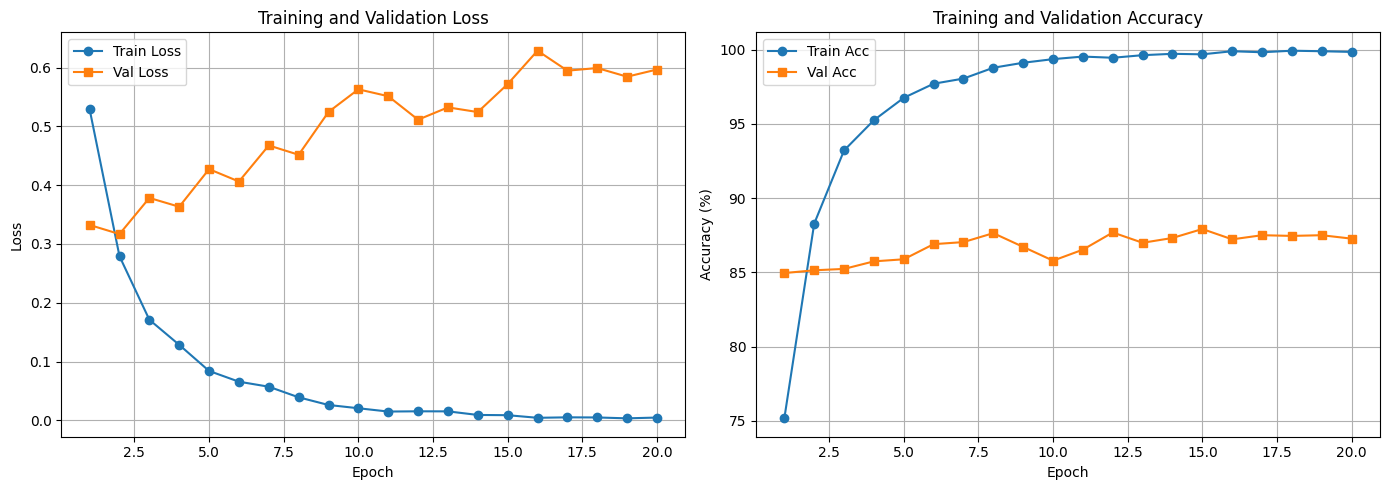

Training history saved to ./checkpoints/training_history.png


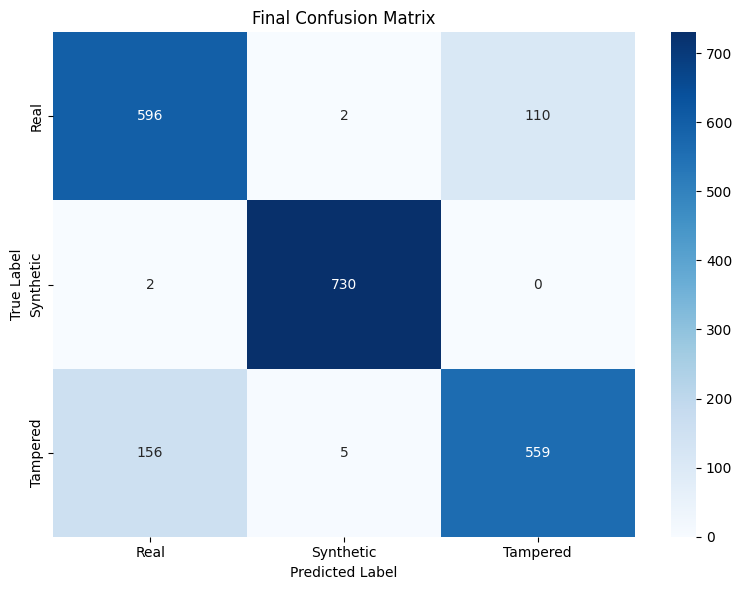

Confusion matrix saved to ./checkpoints/confusion_matrix.png


In [13]:
print("Generating plots...")

# Plot training history
plot_training_history(results, os.path.join(config.save_dir, 'training_history.png'))

# Plot final confusion matrix
plot_confusion_matrix(cm, os.path.join(config.save_dir, 'confusion_matrix.png'))